<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/what_is_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Note: If you want to interactively run this notebook directly through your browser, please use the above link to Google Colab.**

#**What is noise? (Baby don't hurt me)**
___
_by Dirk Gütlin and Josefine Zerbe_


In this notebook, we will look into the matter of EEG noise.

In EEG experiments, an often tiresome part of the data processing for the experimenter is the 'cleaning', i.e. the selection of noisy segments to remove them from the data. This is still mostly done by hand, as it is difficult to discriminate between noise and non-noise segments analytically and requires expertise. However, it takes a lot of time and introduces a new level of subjectivity to the experiment (since every experimenter probably cleans the EEG data differently, according to what they judge to be noise and what not). For this reason, automated noise detection are a hot topic in current EEG (and MEG) research (see Blum et al., 2019; Chang et al., 2018; and Jas et al., 2017).

The noise patterns that we will investigate here are mainly characterized as short bursts caused by muscle artifacts (movements of the face or body, swallowing, pressing your teeth together etc.) and not from continuously noisy channels. We planned on recording our own EEG data to record specific kinds of noise and check how well they can be detected and/or distinguished. Unfortunately, this was not possible as the Institute of Cognitive Science (IKW) and the EEG Laboratory are temporarily closed due to the Covid-19 pandemic. Thus, we replaced it by a recording of one subject from another study, where the experimenters tried to replicate the effect of the N170 ERP component by Rossion and Jacques (2008) in a classic lab condition (i.e., the participant was seated and instructed not to move). In principle, we do not care much about the task as we are only interested in the noise.

In the following notebook, we will lead you step-by-step through visualizing EEG data, looking at some noise characteristics, and then define and visualize a simple noise-detection algorithm. The intention was to have an interactive experience, so feel free to try out what happens when you move the sliders in the cells.

___

## Import libraries and data

First, we need to install MNE-Python which is an M/EEG analysis toolbox in Python (this will only take seconds). Do not worry about the installations! Everything is only temporarily installed in Google Colab's hosted runtime -- you do not have to install anything on your computer.

In [1]:
!pip install mne==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.9 MB/s eta 0:00:00


As a next step, we import all necessary libraries. 

In [2]:
# analysis libraries
import mne
import numpy as np
import scipy
from scipy.io import loadmat

# clustering Algorithm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# for plotting and (interactive) visualization
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, fixed

# to connect with Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Now, we only have to import our EEG recording that we want to investigate. The data file is simply loaded from our Google Drive. Again, this will only be saved in Google Colab's runtime, there is no downloading involved.



When loading the data, though, you need to authenticate yourself with your Google account. You'll need this in order to access our shared dataset on Google drive. For authentication, just follow the instructions displayed below the cell or the pop-up window. Saving the EEG data to Google Colab will take about a minute, as the file size is nearly one GB.


In [3]:
# authenticate your google account to get access to google cloud
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# load our EEG data from google drive and save it in our colab runtime
file_id = "1X91RNcYxq9zWw4YpfpusLNbGG5C0LzvA"
drive_file = drive.CreateFile({'id': file_id})
drive_file.GetContentFile('example_recording_bandpass_resample.fdt')

# do the same for the according EEG .set file
file_id = "1l6e-P8FI3QCk1fqq5Du0eZTIEY4Q8zXA"
drive_file = drive.CreateFile({'id': file_id})
drive_file.GetContentFile('example_recording_bandpass_resample.set')

# do the same for our cleaning times annotations
file_id = "1VzBTdqFLD89slEA4_y0BqcBgYVRkj2NC"
drive_file = drive.CreateFile({'id': file_id})
drive_file.GetContentFile('example_recording_cleaningTimes.mat')

## Investigate noise

We read the raw, unprocessed EEG data file from our runtime with MNE-Python for preprocessing. Then, we pick the specific channels that we are interested in (to reduce the overall data size).

In [4]:
# read raw recording
raw = mne.io.read_raw_eeglab(input_fname="/content/example_recording_bandpass_resample.set", preload=True)

# pick a smaller set of channels
chs = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz',
       'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']
raw.pick_channels(chs)

# reset annotations to the data
raw.set_annotations(None)

Reading /content/example_recording_bandpass_resample.fdt


<ipython-input-4-efb56723a5f2>:2: RuntimeWarning: Unknown types found, setting as type EEG:
eye: ['INPUT', 'L_AREA', 'L_GAZE_X', 'L_GAZE_Y', 'TIME']
  raw = mne.io.read_raw_eeglab(input_fname="/content/example_recording_bandpass_resample.set", preload=True)
<ipython-input-4-efb56723a5f2>:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(input_fname="/content/example_recording_bandpass_resample.set", preload=True)
<ipython-input-4-efb56723a5f2>:2: RuntimeWarning: Data file name in EEG.data (2_ITW_Lab_subj3_bandpass_resample_deblank.fdt) is incorrect, the file name must have changed on disk, using the correct file name (example_recording_bandpass_resample.fdt).
  raw = mne.io.read_raw_eeglab(input_fname="/content/example_recording_bandpass_resample.set", preload=True)


Reading 0 ... 1561880  =      0.000 ...  3050.547 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEEGLAB | example_recording_bandpass_resample.fdt, 19 x 1561881 (3050.5 s), ~226.5 MB, data loaded>

For comparison purposes, we also include the cleaning annotations file of the same EEG data set, in which the experimenters marked the noise by hand.

In [5]:
# read the marked data
marked_data = loadmat("/content/example_recording_cleaningTimes.mat")
marked_segments = raw.times[marked_data["tmprej"][:,2:4].astype(int)]

# add the markers to our raw data
annot = mne.Annotations(onset=marked_segments[:, 0],
                        duration=marked_segments[:, 1] - marked_segments[:, 0],
                        description="Marked Bad")
raw.set_annotations(annot)

<RawEEGLAB | example_recording_bandpass_resample.fdt, 19 x 1561881 (3050.5 s), ~226.5 MB, data loaded>

After everything has been loaded and set up, we can start to investigate the noise of our data file.

We define a plotting function that can show us a frame of the recording for a time interval. The interval can be chosen manually in the following. For each frame, it plots a wavelet time-frequency transform of the data, the autocorrelation, the distribution of samples, and the peak-to-peak difference for each channel. The peak-to-peak difference is the difference between the largest value in a time window and the smallest, and it is an important measurement in automated cleaning. Autoreject (Jas et al., 2016) works exclusively on the peak-to-peak difference. There are, of course, other automated noise-detection algorithms but we do not specifically focus on them.

In [6]:
def autocorr(x):
  """Gives the autocorrelation function of a signal."""
  result = np.correlate(x, x, mode='full')
  return result[result.size//2:]

def plot_window(raw, start, duration=2):
  """Plot different noise characteristics in raw EEG data."""
  # define some constants
  sfreq = raw.info["sfreq"]
  events = np.array([[int(start*sfreq), 0, 1],
                     [int((start+duration)*sfreq), 0, 1]])
  freqs = np.logspace(np.log10(5), np.log10(150), 20)

  # get the characteristics that we want to plot
  tfr = mne.decoding.TimeFrequency(freqs, sfreq=sfreq, n_cycles=3.0, output="power")
  cur_data, times = raw.get_data(start=int(start*sfreq),
                                 stop=int((start + duration)*sfreq),
                                 return_times=True)
  cur_avg = np.mean(cur_data, axis=0)
  cur_ptp = np.array([np.max(chan) - np.min(chan) for chan in cur_data])

  # plot the raw data
  raw.plot(events=events, start=start-5, duration=15,
          scalings={"eeg":1e-4}, event_color="red")
  plt.show();

  # create second plot  for all oothe figures
  plt.figure(figsize=[18,4])

  # time-frequency plot of our window
  plt.subplot(1, 4, 1)
  plt.pcolormesh(tfr.transform(cur_avg[np.newaxis, :])[0], vmax=1e-8)
  idx = [i for i in np.arange(len(freqs)) if i in plt.yticks()[0]]
  plt.yticks(idx, [int(freqs[i]) for i in idx])
  plt.ylabel("Log-Frequency (Hz)")
  plt.xlabel("Time (s)")
  plt.title("Frequency Spectrum")
  idx = [i for i in np.arange(len(times)) if i in plt.xticks()[0]]
  plt.xticks(idx, np.round([times[i] for i in idx], 2))

  # plot the autocorrelations of our window
  plt.subplot(1, 4, 2)
  plt.plot(times - start, autocorr(cur_avg))
  plt.ylabel(r"Autocorrelation $\rho$")
  plt.ylim(-4e-8, 1e-7)
  plt.xlabel("Delay (s)")
  plt.title("Autocorrelation Function")

  # plot the distribution of our values
  plt.subplot(1, 4, 3)
  plt.hist(np.reshape(cur_data*1000, newshape=-1), bins="sqrt", density=True)
  plt.ylim(0,100)
  plt.ylabel("Distribution of all samples in window")
  plt.xlim(-.15, .15)
  plt.xlabel("Sample Magnitude (mV)")
  plt.title("Distribution of Samples")


  # plot the peak-to-peak of all channels
  plt.subplot(1, 4, 4)
  plt.bar(raw.ch_names, cur_ptp*1e3)
  plt.ylim(0,2.5)
  plt.xlabel("Channels")
  plt.ylabel(r"Peak-to-peak difference ($\mu v$)")
  plt.title("Peak-to-Peak difference over channels")
  plt.show();

Let's plot the data!

We use ipywidgets to interactively look through the data, and see how the plots look in a noisy segment compared to clean data.
- The two red lines in our main recording show the left bound and the right bound of the window frame that we look at.
- The '*time*' slider decides at which second our window frame starts.
- The '*window length*' slider determines how long the inspected window frame should be.
- The segments marked in blue are the data segments that were annotated to be noise ('Marked bad') by the experimenters.

Feel free to play around with the sliders, to see what happens when you put the window over noisy data as compared to clean data. Also note that channel Cz was used as reference which is why it looks flat in our recording.

In [7]:
layout = {'width': '500px'}; style = {'description_width': '140px'}
t_slider = FloatSlider(value = 0., min= 1000., max =  1100., step = 0.1, description = 'Time (s):', continuous_update=False, layout=layout, style=style)
w_slider = FloatSlider(value = 2., min= 1., max = 5., step = 0.1, description = 'Window length (s):', continuous_update=False, layout=layout, style=style)

interactive(plot_window, raw=fixed(raw), start=t_slider, duration=w_slider)

interactive(children=(FloatSlider(value=1000.0, continuous_update=False, description='Time (s):', layout=Layou…

In the following plots, you can see how the data looks like at a clean interval. Note that we cannot see anything in the time-frequency domain (at least not at the scale that we set our plots to). Also, the autocorrelation is relatively smooth, and the distribution of samples is relatively sharp (i.e. it has a small variance). Lastly, the peak-to-peak differences are mostly quite small.

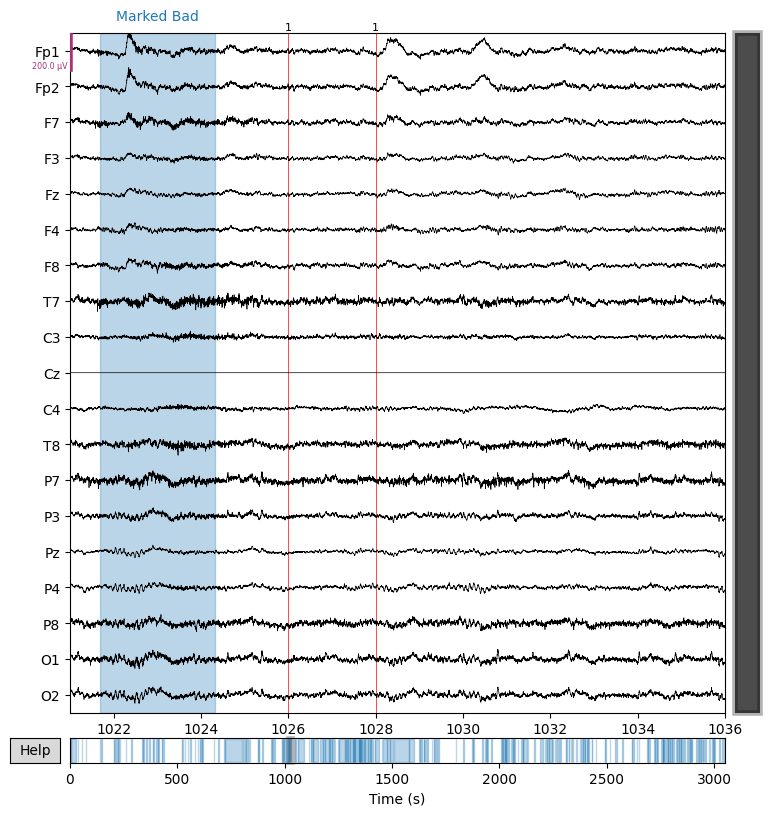

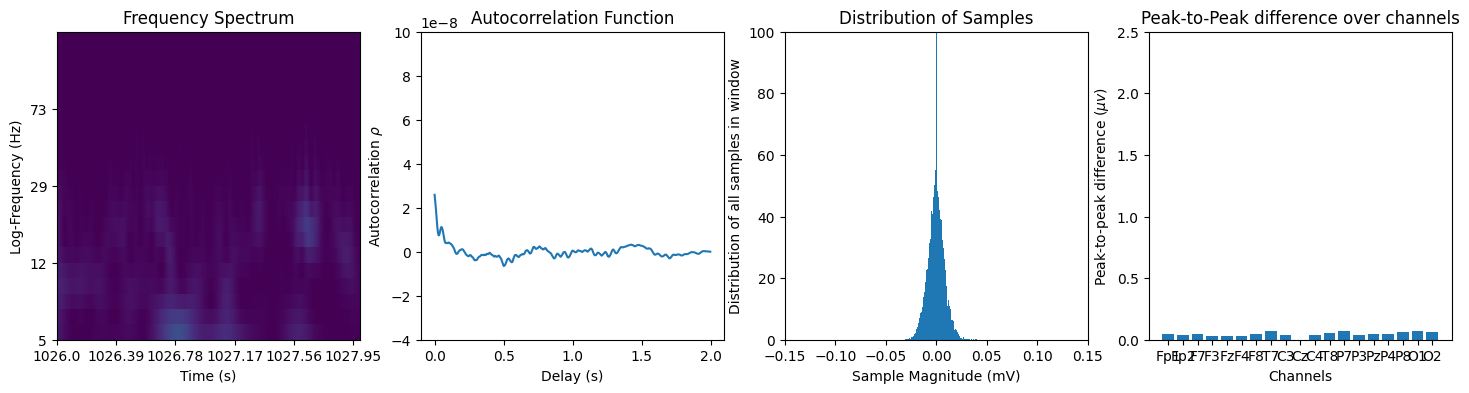

In [8]:
plot_window(raw, start=1026, duration=2)

As a comparison, we see what a noisy segment looks like in the next plots. For a noisy segment, we see bursts of high-frequency activity, especially around 50 to 100 Hz. Comparing it further, the autocorrelation looks not smooth at all but 'wild' and very noisy. The distribution of samples is much flatter than before, indicating a high variance, and the peak-to-peak differences grow very large, at least for some channels.

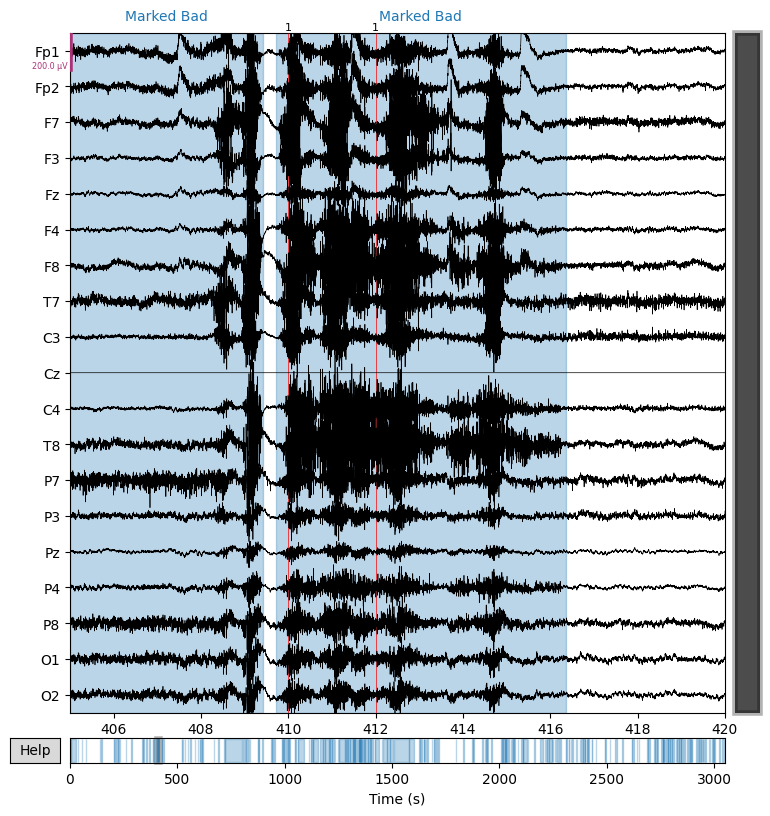

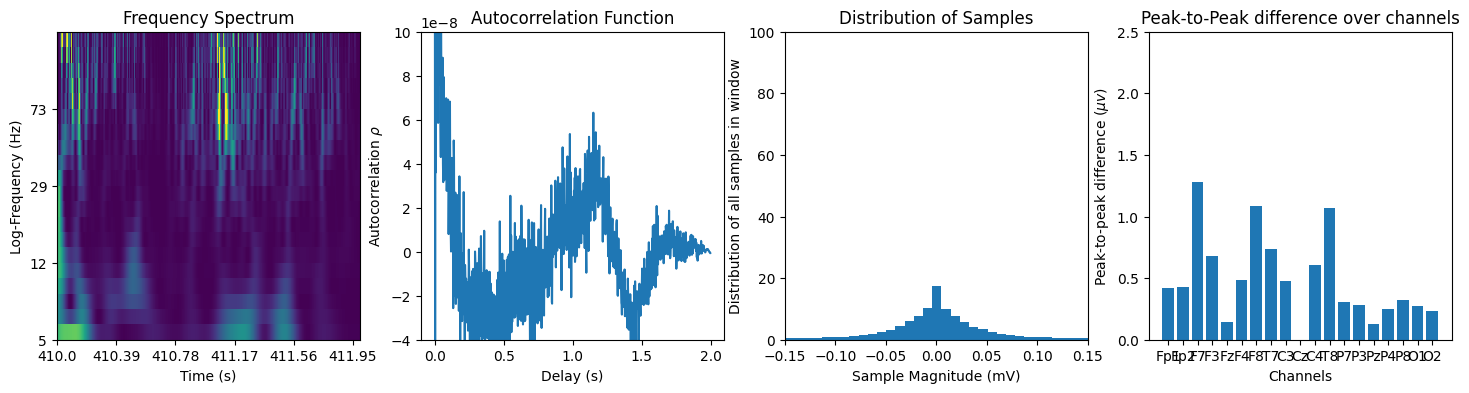

In [9]:
plot_window(raw, start=410, duration=2)

However, it is not always as clear cut as it seems. There are segments that can be clearly distinguished as noise by a human annotator, but will look like clean data when we plot its characteristics as we just did before. This is mainly caused by calculating most measures over an all-channel average meaning that a few noisy channels will not be noticed.

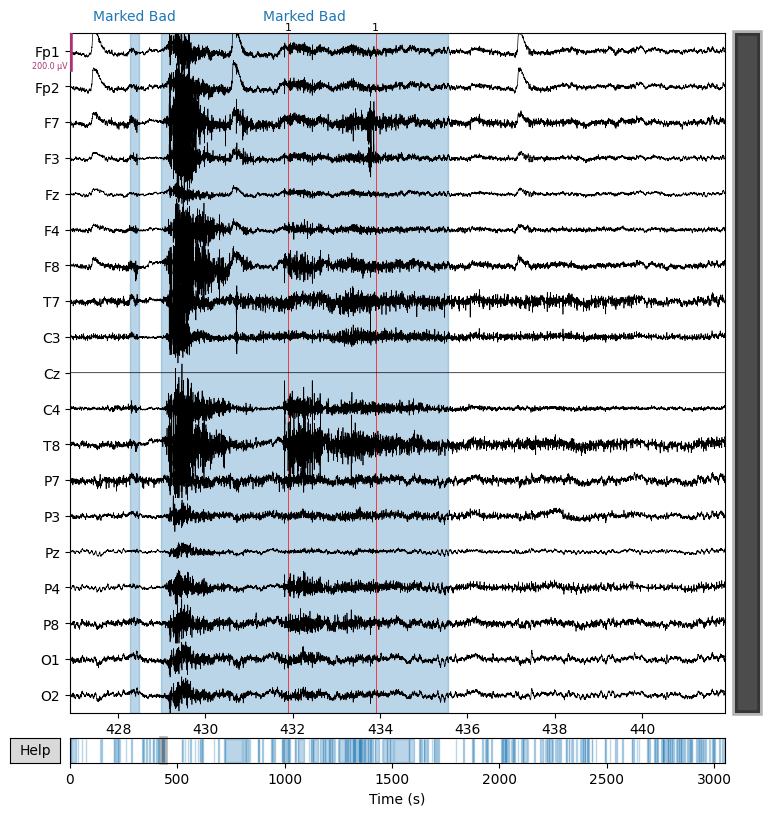

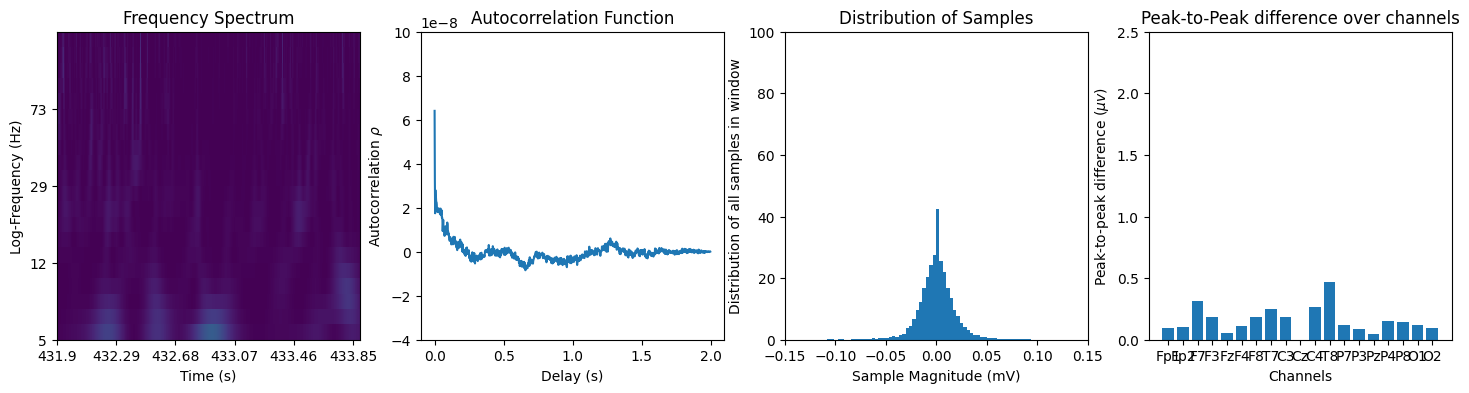

In [10]:
plot_window(raw, start=431.9, duration=2)

Of course, if we select only the noisiest channels here, we will see the typical noise characteristics.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-11-7cddf17ec5d7>:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  cropped_raw = raw.copy().pick_channels(["T8", "C4"])


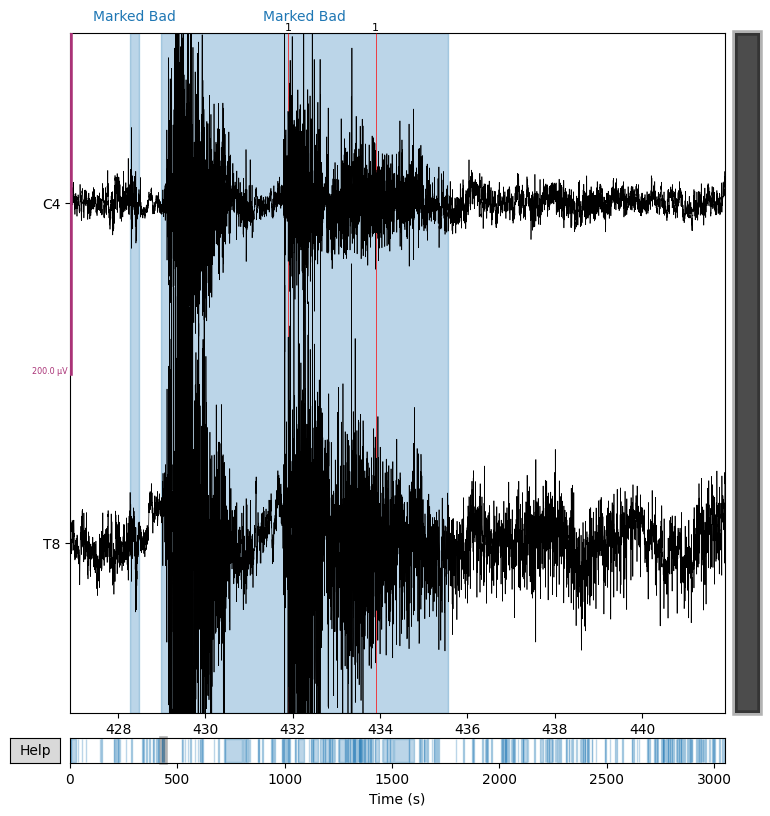

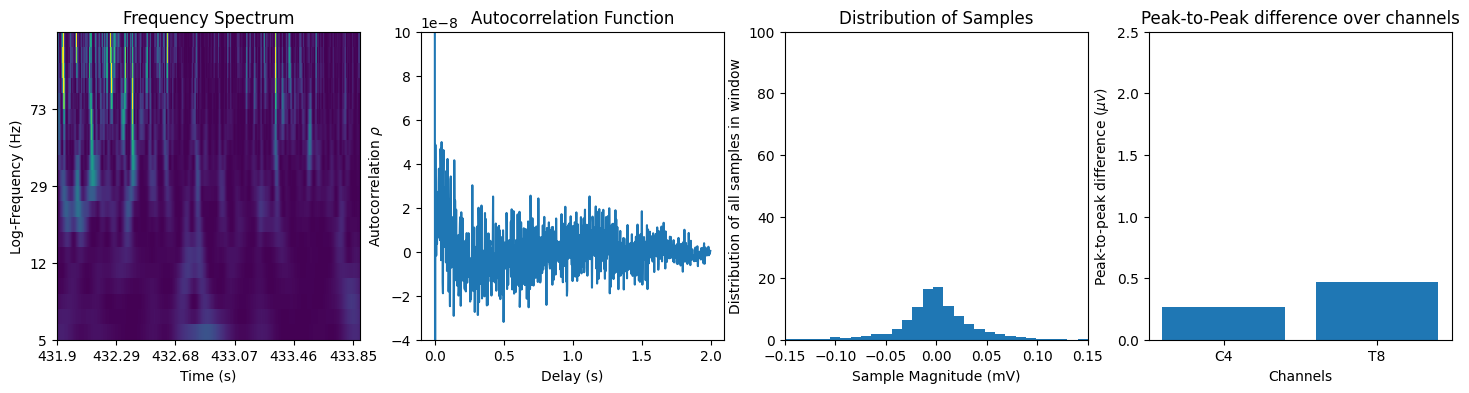

In [11]:
cropped_raw = raw.copy().pick_channels(["T8", "C4"])
plot_window(cropped_raw ,start=431.9, duration=2)

## Automated noise detection

After we have visualized and inspected our data, and checked out the functions that can help us detect noise, we can now use some of these noise characteristics to create an automated noise detection -- by feeding them to an unsupervised clustering algorithm.

For now, we will only use the time-frequency characteristics and the peak-to-peak differences. Autoreject uses a peak-to-peak cross-validation approach, but we settled for a clustering approach because it is faster and easy to visualize.

Similar to autoreject, this will not work on continuous raw data, but only on epoch data (i.e., data that is separated into small segments). We will introduce 'sham epochs' for that purpose, which will split our raw data into 'epochs' of one second for every second in our recording.

In [12]:
# each new second in the recording will be a new event
steady_samples = np.arange(len(raw))[::int(raw.info["sfreq"])][:-1]
events = np.vstack([steady_samples,
                    np.zeros(len(steady_samples)),
                    np.ones(len(steady_samples))]).astype(int).T

# create an epochs object with our sham events
epochs = mne.Epochs(raw, events, tmin=0, tmax=1, baseline=(0, 0))

Not setting metadata
3050 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


Next, we calculate the frequency data. This time, we will not calculate a time-resolved time-frequency transform (as in our previous plots), but only one spectrum for the entire epoch. Further, we will only calculate frequencies between 50 and 100 Hz, and then average them. In the end, we will have one number per channel and epoch (second), which describes the average power between 50 and 100 Hz. If this average frequency is very high, we could infer that the according epoch is very noisy.

In [13]:
psds, freqs = mne.time_frequency.psd_array_welch(epochs.get_data(), epochs.info["sfreq"],
                                                 fmin=50, fmax=100)
mean_psd = np.mean(psds, axis=-1)

Using data from preloaded Raw for 3050 events and 513 original time points ...
0 bad epochs dropped
Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s finished


Likewise, we can calculate the peak-to-peak differences within each epoch and for each channel. As we have seen already, noisy epochs are usually associated with high peak-to-peak distances.

In [14]:
ptp_diffs = np.max(epochs.get_data(), axis=-1) - np.min(epochs.get_data(), axis=-1)

Using data from preloaded Raw for 3050 events and 513 original time points ...
Using data from preloaded Raw for 3050 events and 513 original time points ...


Let's create a scatter plot of all epochs, between average power and peak-to-peak difference, to see if we can distinguish any clusters already. Note that for visualisation, we average both measures across channels (in order to plot them in 2D). Our real data will contain some more information, since both measures are calculated for all channels.

We see that there are some epochs that are already clearly distinguishable as noise, though generally, there are no clearly-defined clusters here but rather a continuous spectrum from clean epochs to noisy epochs.

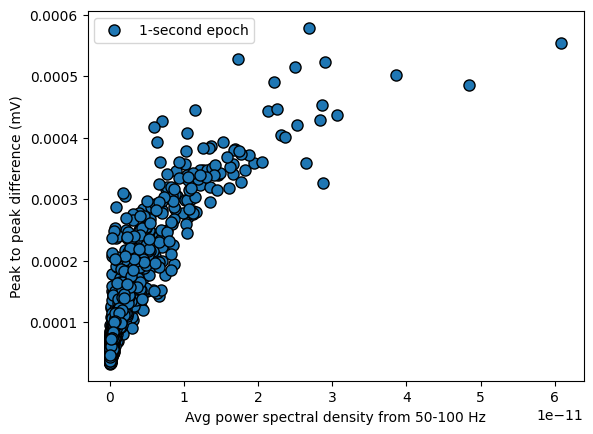

In [15]:
plt.plot(np.mean(mean_psd, axis=1), np.mean(ptp_diffs, axis=1),
         'o', markeredgecolor='k', markersize=8)
plt.xlabel("Avg power spectral density from 50-100 Hz")
plt.ylabel("Peak to peak difference (mV)")
plt.legend(["1-second epoch"])
plt.show();

Now we fit our unsupervised clustering algorithm, by feeding it the psd and peak-to-peak data. Note that we do not use any of the hand-marked data for data detection here. Our results here will be exclusively derived from our unsupervised clustering algorithm (and could therefore also be applied to an unmarked dataset).

We tell the clustering algorithm to form two clusters, since this makes the most sense (i.e., 'noise' or 'no noise'). However, it might also be reasonable that more than two clusters will lead to better results, since the algorithm will be able to distinguish more precisely. You can try out setting it to `n_clusters = 3` to see what happens if we allow three clusters. We already adapted the code for this case. If you want to look at more clusters, you might have to investigate for yourself which clusters belong to noise and which are clean data.

In [16]:
# set the number of clusters
n_clusters = 2

# concatenate the input and fit the cluster
cluster_input = np.concatenate([mean_psd, ptp_diffs], axis=-1)
cluster = AgglomerativeClustering(n_clusters=n_clusters).fit(StandardScaler().fit_transform(cluster_input))

Then, we visualize the formed clusters, by plotting the results of our clustering algorithm on our previous average plot.

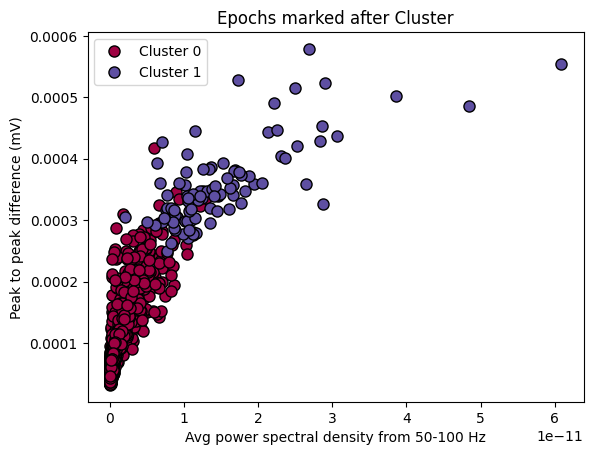

In [17]:
# use the channel average again for our plots
cluster_vars_avg = np.vstack([np.mean(mean_psd, axis=1),
                             np.mean(ptp_diffs, axis=1)]).T

# Number of clusters in labels
labels = cluster.labels_

# Define the colors four our clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

# fplot all cluster classes in a different color
plt.figure()
for k, col in zip(unique_labels, colors):

    class_member_mask = (labels == k)

    xy = cluster_vars_avg[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)

plt.title("Epochs marked after Cluster")
plt.xlabel("Avg power spectral density from 50-100 Hz")
plt.ylabel("Peak to peak difference (mV)")
plt.legend(["Cluster " + str(i) for i in unique_labels])
plt.show();

We can transfer our results to our raw data again, by creating data annotations from our clustered epochs and add them to the raw data.

In [18]:
# select the clusters that we want to mark as noise
# we find the correct culsters, by inspecting the data
noise_clusters = [1]
if n_clusters == 3:
  noise_clusters = [0, 1]

# define your own noise clusters with
#noise_clusters = [0, 2, ..., cluster_n]

# create a boolean index that tells if one sample is part of a noise cluster
noise_idx = [i in noise_clusters for i in cluster.labels_]

# Use our clusters and sham epochs to create Annotations to the data
time_segments = raw.times[steady_samples[noise_idx]]
annot = mne.Annotations(onset=time_segments,
                        duration=np.ones(len(time_segments)),
                        description="BAD")
raw_auto = raw.copy()
raw_auto.set_annotations(None)
raw_auto.set_annotations(annot)

<RawEEGLAB | example_recording_bandpass_resample.fdt, 19 x 1561881 (3050.5 s), ~226.5 MB, data loaded>

Finally, we plot the raw data again, this time checked for noise by our automated clustering algorithm. The red segments are marked by the clustering algorithm as stemming from a 'noisy' cluster. As previously mentioned, there are no manual markings involved in the detection of these patterns. In general, the only manually-added part here is the selection of the noise clusters that we did above (i.e., choose the number of clusters and then tell the algorithm which of them is which).

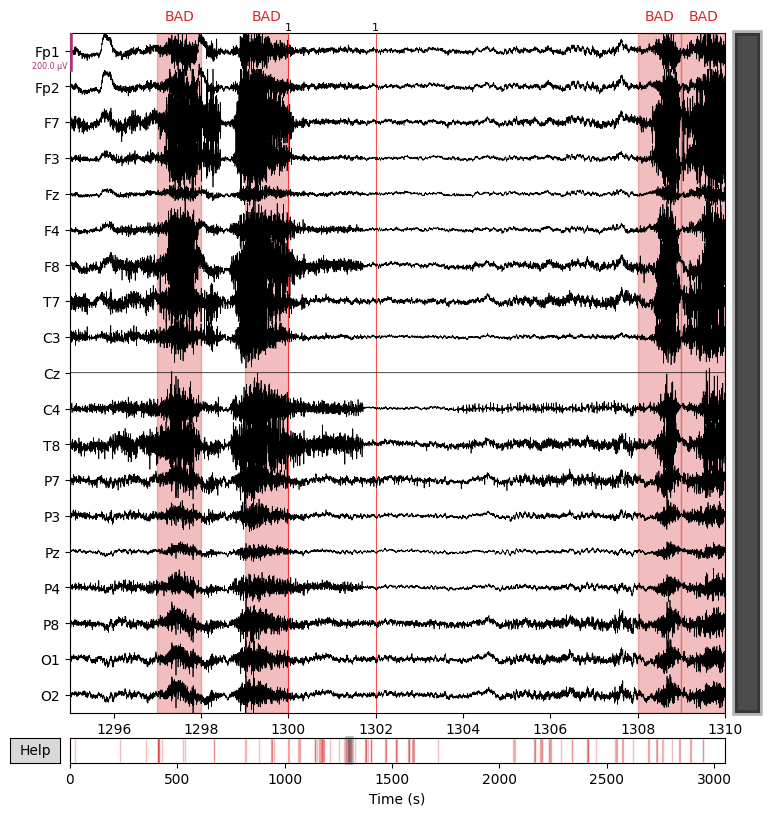

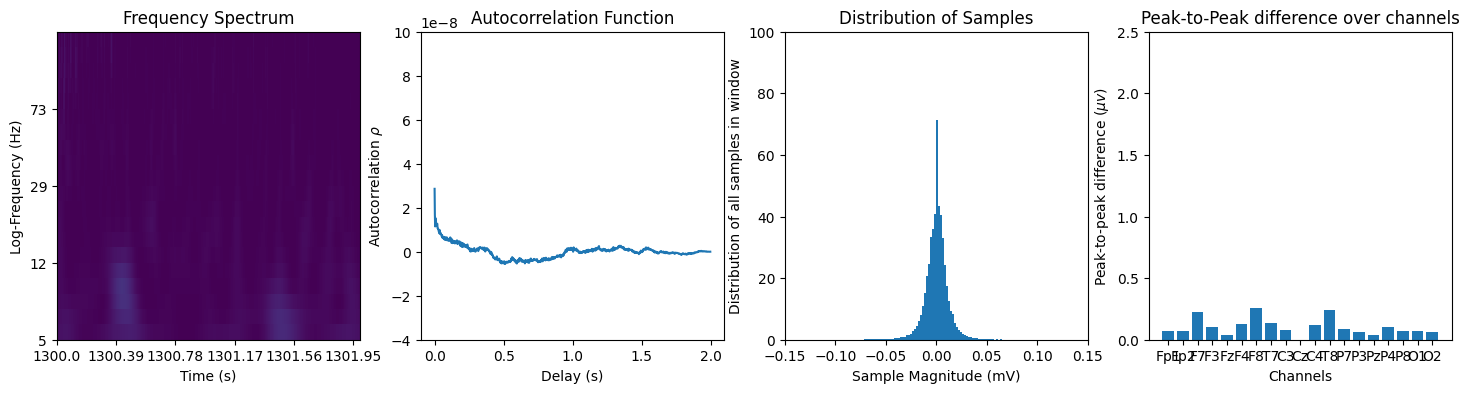

In [19]:
plot_window(raw_auto, start=1300., duration=2.);

When investigating the plot, note that our algorithm is bound to the previously defined one-second intervals. Thus, sometimes it will look like the noise detection has a very large margin. We also see that the algorithm works only for very large bursts, while a lot of the noise still goes undetected. If you set `n_clusters = 3` you will already get a better noise detection, including a seperate cluster for more subtle noise segments.

In [20]:
layout = {'width': '500px'}; style = {'description_width': '140px'}
t_slider = FloatSlider(value = 1250., min= 1200., max =  1350., step = 0.1, description = 'Time (s):', continuous_update=False, layout=layout, style=style)
w_slider = FloatSlider(value = 2., min= 1., max = 5., step = 0.1, description = 'Window length (s):', continuous_update=False, layout=layout, style=style)

interactive(plot_window, raw=fixed(raw_auto), start=t_slider, duration=w_slider)

interactive(children=(FloatSlider(value=1250.0, continuous_update=False, description='Time (s):', layout=Layou…

To conclude our project, we see that our automated noise-detection algorithm seems to correctly classify most of the noise.

If we use two clusters, visual inspection shows that it only recognizes large bursts. Smaller noise patterns go largely undetected. This becomes especially clear, when comparing the segments marked by the algorithm to the segments that were marked by the human annotator. However, if you run the code with three clusters it already gives a reasonable noise detection. Not only the larger bursts will be recognized but even smaller noise patterns are correctly identified by the algorithm. It even largely matches the hand-annotated markings from the experimenter. Despite these positive results, the algorithm is surely far from perfect as it is only a 'simple' version for the scope of this course. There are many possibilities to enhance it further, e.g. by including more data and more characteristic variables.

After the lockdown, we would still like to try if we can record our own noise data to check out (if possible) how well the algorithm can discriminate different types of EEG noise patterns.

We hope you had some fun with our notebook and maybe even gained some impressions of EEG noise and how it can be automatically detected!

## References

___

Blum, S., Jacobsen, N. S., Bleichner, M. G., & Debener, S. (2019). A Riemannian modification of artifact subspace reconstruction for EEG artifact handling. Frontiers in human neuroscience, 13, 141.

Chang, C. Y., Hsu, S. H., Pion-Tonachini, L., & Jung, T. P. (2018, July). Evaluation of artifact subspace reconstruction for automatic EEG artifact removal. In 2018 40th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC) (pp. 1242-1245). IEEE.

Jas, M., Engemann, D. A., Bekhti, Y., Raimondo, F., & Gramfort, A. (2017). Autoreject: Automated artifact rejection for MEG and EEG data. NeuroImage, 159, 417-429.

Rossion, B., & Jacques, C. (2008). Does physical interstimulus variance account for early electrophysiological face sensitive responses in the human brain? Ten lessons on the N170. Neuroimage, 39(4), 1959-1979.
___